In [2]:
from __future__ import division, print_function

## Evaluate deep model for sequence editing from Keras

### Obtain data and keras model
We will load a keras model and compute importance scores

#### Download the keras model
Download a model with 2 strided convolutional layers and 2 dense layers, similar to the one in the paper.

Tweaking

### Load the keras model
A user warning about compilation is generated because this model was converted from a keras 1.2 model and was thus never compiled for training.

In [5]:
import keras
saved_model_file = "/home/ubuntu/CRISPR-BE-RNA-editing/model_outputs/ABE-19FEB/overall_model.h5"
keras_model = keras.models.load_model(saved_model_file)
keras_model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv1D)               (None, 94, 1024)          41984     
_________________________________________________________________
downsample1 (MaxPooling1D)   (None, 94, 1024)          0         
_________________________________________________________________
conv2 (Conv1D)               (None, 90, 64)            327744    
_________________________________________________________________
downsample2 (MaxPooling1D)   (None, 90, 64)            0         
_________________________________________________________________
dropout1 (Dropout)           (None, 90, 64)            0         
_________________________________________________________________
conv3 (Conv1D)               (None, 86, 64)            20544     
_________________________________________________________________
conv4 (Conv1D)               (None, 84, 64)            12352     
__________

### Load the data

In [3]:
import gzip
import glob
import numpy as np
import random
import pandas

seqlen = 101
data_path = "."

def read_fasta(f):
    def gen():
        for l in gzip.open(f, "r"):
            if l.startswith(b'>'):
               library, location, strand, rate, cov, anno, gene = l.split(b'_')
            else:
                yield l.strip().decode().lower(), float(rate)
    stack = pandas.DataFrame.from_records([v for v in gen()], columns="sequence rate".split())
    print(f, stack.shape[0])
    return stack


def read_fasta_to_arrays():
    fasta_files = sorted(glob.glob(data_path + '/*.fasta.gz'))
    fasta_arrays = [read_fasta(f) for f in fasta_files]
    return fasta_arrays

weighted_arrays = read_fasta_to_arrays()

('./test_ABE.fasta.gz', 1000)


In [10]:
import numpy as np

#this is set up for 1d convolutions where examples
#have dimensions (len, num_channels)
#the channel axis is the axis for one-hot encoding.
def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),5), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if(i == 50):
            char_idx = 4 # this corresponds to the edit - specific channel
        elif (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1
            
onehot_data = np.array([one_hot_encode_along_channel_axis(seq) for seq in weighted_arrays[0].sequence])

In [12]:
onehot_data.shape

(1000, 101, 5)

## Prepare the deeplift models

### Model conversion
Convert the keras models to deeplift models capable of computing importance scores using DeepLIFT-RevealCancel, gradients and guided backprop

In [38]:
import deeplift
from deeplift.layers import NonlinearMxtsMode
from deeplift.conversion import kerasapi_conversion as kc

#Three different models, one each for RevealCancel, Gradient and GuidedBackprop
revealcancel_model = kc.convert_model_from_saved_files(
                            h5_file=saved_model_file,
                            nonlinear_mxts_mode=NonlinearMxtsMode.RevealCancel)
#grad_model = kc.convert_model_from_saved_files(
#                            h5_file=saved_model_file,
#                            nonlinear_mxts_mode=NonlinearMxtsMode.Gradient)
#guided_backprop_model = kc.convert_model_from_saved_files(
#                            h5_file=saved_model_file,
#                            nonlinear_mxts_mode=NonlinearMxtsMode.GuidedBackprop)
rescale_conv_revealcancel_fc = kc.convert_model_from_saved_files(
                            h5_file=saved_model_file,
                            nonlinear_mxts_mode=NonlinearMxtsMode.DeepLIFT_GenomicsDefault)


nonlinear_mxts_mode is set to: RevealCancel
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
nonlinear_mxts_mode is set to: DeepLIFT_GenomicsDefault
For layer 0 the preceding linear layer is preact_0 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
For layer 2 the preceding linear layer is preact_2 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
Heads-up: current implementation assumes maxpool layer is followed by a linear transformat

### Sanity checks
To ensure that the conversion happend correctly, ensure that the models give identical predictions

If you are using a functional model, see this issue for how to adapt the code: https://github.com/kundajelab/deeplift/issues/54

In [13]:
from deeplift.util import compile_func
import numpy as np
from keras import backend as K

deeplift_model = revealcancel_model
deeplift_prediction_func = compile_func([deeplift_model.get_layers()[0].get_activation_vars()],
                                       deeplift_model.get_layers()[-1].get_activation_vars())
original_model_predictions = keras_model.predict(onehot_data, batch_size=200)
converted_model_predictions = deeplift.util.run_function_in_batches(
                                input_data_list=[onehot_data],
                                func=deeplift_prediction_func,
                                batch_size=200,
                                progress_update=None)
print("difference in predictions:",np.max(np.array(converted_model_predictions)-np.array(original_model_predictions)))
assert np.max(np.array(converted_model_predictions)-np.array(original_model_predictions)) < 10**-5
predictions = converted_model_predictions

('difference in predictions:', 0.0)


## Compute importance scores

### Compile various scoring functions
Using the deeplift models, we obtain the functions capable of computing the importance scores.

In [39]:
from keras import backend as K
import deeplift
from deeplift.util import get_integrated_gradients_function

#revealcancel_func = revealcancel_model.get_target_contribs_func(find_scores_layer_idx=0, target_layer_idx=-1)
genomics_func = rescale_conv_revealcancel_fc.get_target_contribs_func(find_scores_layer_idx=0, target_layer_idx=-1)

### Call scoring functions on the data

In [41]:
from collections import OrderedDict
method_to_task_to_scores = OrderedDict()

X_test = onehot_data

scores = np.array(genomics_func( # revealcancel_func
            task_idx=0,
            input_data_list=[X_test],
            input_references_list=[np.zeros_like(X_test)],
            batch_size=1000,
            progress_update=None))


## Plot figures

### Prepare various functions to aid in plotting

In [43]:
scores2= np.delete(scores, 4, 2)


In [37]:
scores2[600]


array([[-0.0000000e+00, -6.1481178e-04, -0.0000000e+00, -0.0000000e+00],
       [-0.0000000e+00, -3.6691431e-02, -0.0000000e+00, -0.0000000e+00],
       [-0.0000000e+00,  2.1519423e-02, -0.0000000e+00, -0.0000000e+00],
       [-0.0000000e+00,  6.3692003e-02, -0.0000000e+00, -0.0000000e+00],
       [-0.0000000e+00, -0.0000000e+00,  4.9891794e-01, -0.0000000e+00],
       [-0.0000000e+00, -0.0000000e+00, -0.0000000e+00, -5.8200312e-01],
       [-0.0000000e+00, -0.0000000e+00,  1.2180684e+00, -0.0000000e+00],
       [-4.8506033e-01, -0.0000000e+00, -0.0000000e+00, -0.0000000e+00],
       [-3.3337188e-01, -0.0000000e+00, -0.0000000e+00, -0.0000000e+00],
       [-0.0000000e+00,  8.0002546e-01, -0.0000000e+00, -0.0000000e+00],
       [-1.8944633e-01, -0.0000000e+00, -0.0000000e+00, -0.0000000e+00],
       [-0.0000000e+00,  9.0621471e-02, -0.0000000e+00, -0.0000000e+00],
       [-0.0000000e+00, -0.0000000e+00,  2.2975230e-01, -0.0000000e+00],
       [-7.9484689e-01, -0.0000000e+00, -0.0000000e

Preceding 10 bases: tgtgctaga
Preceding 10 bases: atggaaaaag
Edit rate: 0.0152
Predicted editing rate: [0.01822909]


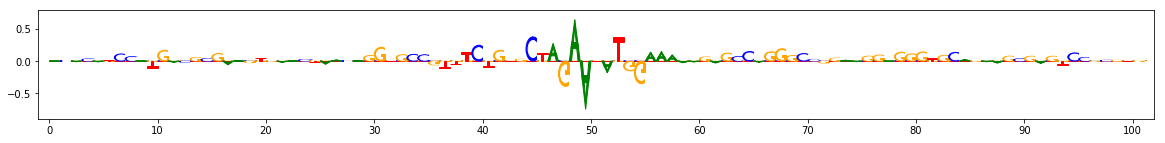

In [56]:
%matplotlib inline
from deeplift.visualization import viz_sequence

def inv_logit(p):
    return np.exp(p) / (1 + np.exp(p))

idx_view = 18
print("Preceding 10 bases: " + weighted_arrays[0].sequence[idx_view][40:49])
print("Preceding 10 bases: " + weighted_arrays[0].sequence[idx_view][51:61])
print("Edit rate: " + str(weighted_arrays[0].rate[idx_view]))
print("Predicted editing rate: " + str(inv_logit(predictions[idx_view])))

scores_for_idx = scores2[idx_view]

viz_sequence.plot_weights(scores_for_idx, subticks_frequency=10)